In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [143]:


def get_table_names(database_file='assets/test_data.db'):
    """Return a list of table names."""
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [table[0] for table in cursor.fetchall()]
    return tables

def read_table(table_name, database_file='assets/test_data.db'):
    """Read a whole table and return it as a pandas DataFrame."""
    try:
        conn = sqlite3.connect(database_file)
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
        return df
    except Exception as e:
        print(f"Error reading table {table_name}: {e}")
        return None

def plot_sensor_data(df, table_name):
    """
    Plots sensor data (x, y, z) from a DataFrame.
    """
    if df.empty:
        print(f"The {table_name} table is empty. Nothing to plot.")
        return

    # Convert timestamp to seconds from the start
    # Change this line in compute_relative_angle_compass():
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')  
    time_seconds = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

    plt.figure(figsize=(14, 7))
    
    plt.plot(time_seconds, df['x'], label='X-axis')
    plt.plot(time_seconds, df['y'], label='Y-axis')
    plt.plot(time_seconds, df['z'], label='Z-axis')
    
    sensor_type = table_name.split('_')[0].capitalize()
    plt.xlabel('Time (seconds)')
    plt.ylabel(f'{sensor_type} Value')
    plt.title(f'{sensor_type} Data (X, Y, Z) Over Time')
    plt.legend()
    plt.grid(True)
    
    print(f"Displaying plot for {table_name}. Close the plot window to continue.")
    plt.show()



def compute_relative_angle():
    table_name = 'gyro_data'
    df = read_table(table_name)
    """
    Computes relative angle change from gyro Z and plots it normalized to [-180°, +180°],
    with time on X-axis in seconds. Also shows 95% confidence interval bounds.
    """
    if df.empty:
        print(f"The {table_name} table is empty. Nothing to compute.")
        return

    # Convert timestamp from nanoseconds to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')

    # Compute time in seconds relative to the start
    df['time_s'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

    # Extract gyro Z values (angular velocity in °/s) and timestamps in seconds
    gyro_z = df['z'].values
    time_s = df['time_s'].values

    # Compute time differences between samples in seconds
    dt = np.diff(time_s, prepend=time_s[0])

    # Integrate gyro Z to compute heading change (relative angle)
    relative_angle = np.cumsum(gyro_z * dt)

    # Normalize angle to [-180, +180] degrees
    relative_angle = (relative_angle + 180) % 360 - 180

    # Calculate 95% confidence interval
    gyro_noise = 3  # degrees/second (given bias specification)
    confidence_95 = 1.96 * gyro_noise * np.sqrt(time_s)  # Growing uncertainty with sqrt of time
    
    # Create upper and lower bounds
    upper_bound = relative_angle + confidence_95
    lower_bound = relative_angle - confidence_95

    # Plot relative angle over time with confidence interval
    plt.figure(figsize=(14, 7))
    
    # Plot confidence interval as a shaded region with translucent red
    plt.fill_between(time_s, lower_bound, upper_bound, 
                    color='red', alpha=0.3, 
                    label='95% Confidence Interval')
    
    # Plot the main relative angle line
    plt.plot(time_s, relative_angle, 
            label='Relative Angle Change (°)', 
            color='blue', linewidth=2)
    
    # Plot the confidence interval boundaries with dashed lines
    plt.plot(time_s, upper_bound, 'r--', alpha=0.5, linewidth=1)
    plt.plot(time_s, lower_bound, 'r--', alpha=0.5, linewidth=1)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Relative Angle (°)')
    plt.title(f'Relative Angle Change with 95% Confidence Interval\nGyroscope Z ({table_name})')
    plt.legend()
    plt.grid(True)

    # Print final uncertainty
    final_uncertainty = confidence_95[-1]
    print(f"Final 95% confidence interval at {time_s[-1]:.1f} seconds: ±{final_uncertainty:.2f}°")
    
    print(f"Displaying relative angle plot for {table_name}. Close the plot window to continue.")
    plt.show()

Final 95% confidence interval at 32.6 seconds: ±33.60°
Displaying relative angle plot for gyro_data. Close the plot window to continue.


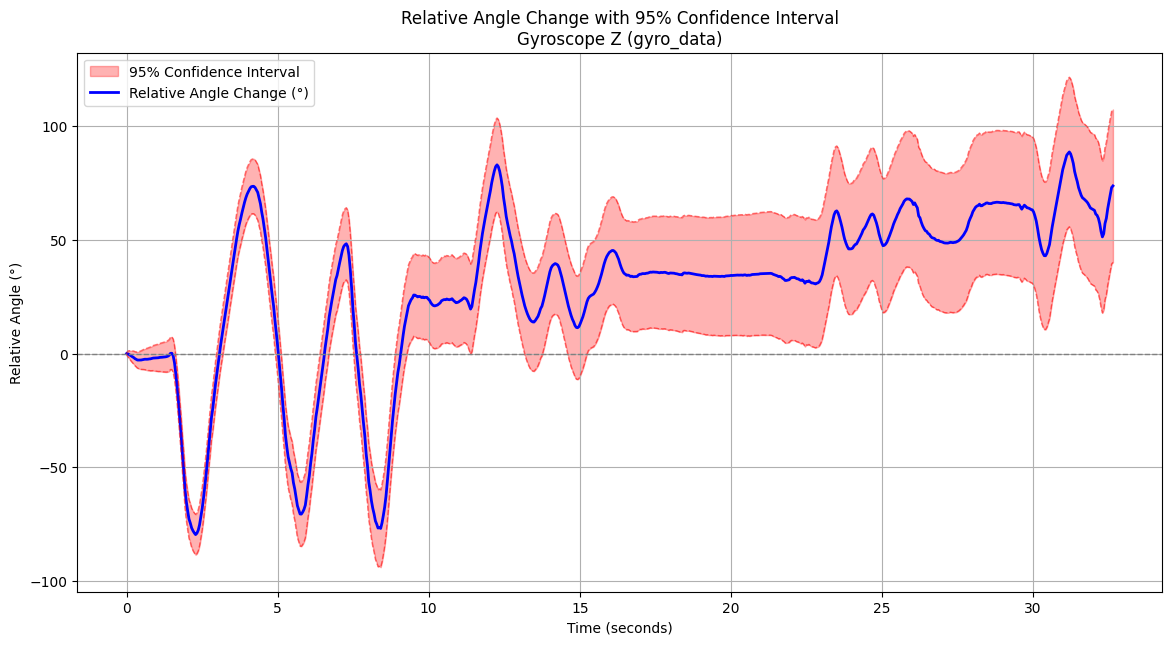

Displaying plot for accel_data. Close the plot window to continue.


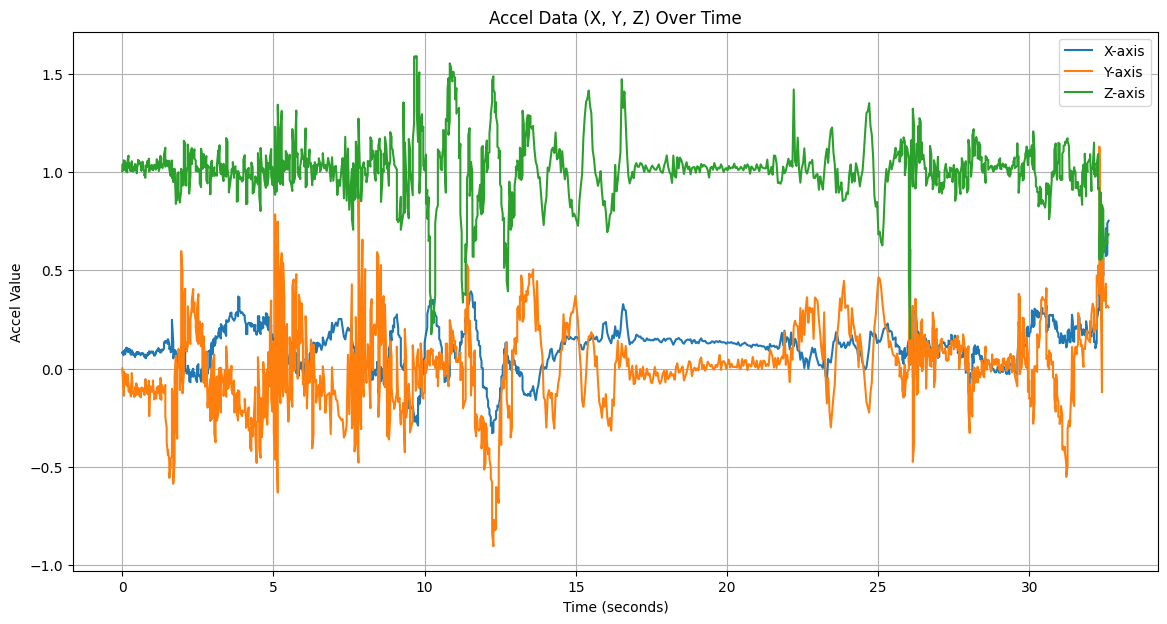

Displaying plot for gyro_data. Close the plot window to continue.


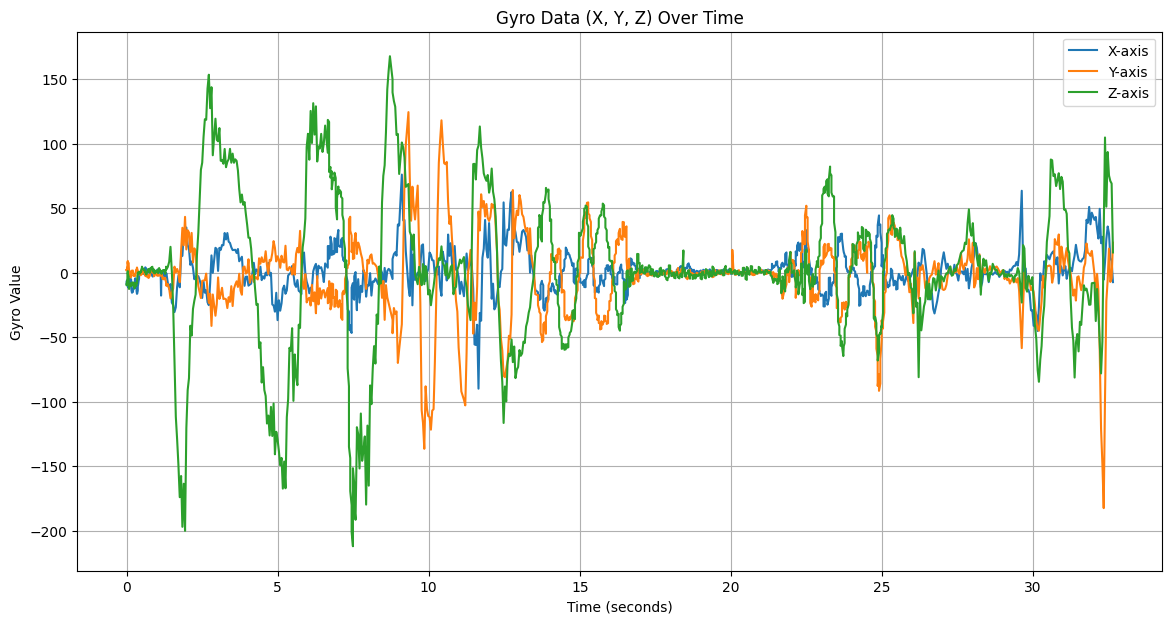

In [144]:
compute_relative_angle()
for table in ['accel_data', 'gyro_data']:
    df = read_table(table)
    plot_sensor_data(df, table)

In [145]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

def compute_relative_angle_compass():
    table_name = 'gyro_data'
    df = read_table(table_name)
    
    if df.empty:
        print(f"The {table_name} table is empty. Nothing to compute.")
        return

    print(f"Data points loaded: {len(df)}")
    print(f"Sample of gyro-Z values: {df['z'].head()}")

    # --- time in seconds ----------------------------------------------------
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ns')
    df['time_s'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
    time_s = df['time_s'].values

    # --- integrate gyro-Z ---------------------------------------------------
    gyro_z = df['z'].values                  # °/s
    dt = np.diff(time_s, prepend=time_s[0])
    heading = np.cumsum(gyro_z * dt)          # ° (relative)
    heading = (heading + 180) % 360 - 180     # wrap to [-180, +180]

    # Create frames for animation
    frames = []
    for i in range(len(time_s)):
        ang = np.deg2rad(heading[i])
        x_tip, y_tip = np.sin(ang), np.cos(ang)
        
        frame = go.Frame(
            data=[
                # Compass circle
                go.Scatter(x=[np.sin(t) for t in np.linspace(0, 2*np.pi, 100)],
                          y=[np.cos(t) for t in np.linspace(0, 2*np.pi, 100)],
                          mode='lines',
                          line=dict(color='black'),
                          showlegend=False),
                # Compass needle
                go.Scatter(x=[0, x_tip],
                          y=[0, y_tip],
                          mode='lines+markers',
                          line=dict(color='red', width=3),
                          marker=dict(size=8, color='red'),
                          showlegend=False),
                # Cardinal directions
                go.Scatter(x=[0, 1.12, 0, -1.12],
                          y=[1.12, 0, -1.12, 0],
                          mode='text',
                          text=['N', 'E', 'S', 'W'],
                          textposition='middle center',
                          textfont=dict(size=12, color='black'),
                          showlegend=False)
            ],
            layout=go.Layout(
                annotations=[
                    dict(x=0, y=-1.3,
                         text=f't = {time_s[i]:.2f} s',
                         showarrow=False),
                    dict(x=0, y=1.3,
                         text=f'Heading: {heading[i]:.1f}°',
                         showarrow=False)
                ]
            )
        )
        frames.append(frame)

    # Create the initial figure
    fig = go.Figure(
        data=frames[0].data,
        layout=go.Layout(
            width=600, height=600,
            xaxis=dict(range=[-1.5, 1.5], showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(range=[-1.5, 1.5], showgrid=False, zeroline=False, showticklabels=False),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[dict(label="Play",
                            method="animate",
                            args=[None, {
                                "frame": {"duration": 40, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}
                            }])]
            )],
            title="Compass Animation"
        ),
        frames=frames
    )

    fig.update_layout(showlegend=False)
    fig.show()


In [146]:


def plot_3d_movement(df, table_name):
    # Convert timestamp to elapsed time in seconds (float)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['time_seconds'] = (df['timestamp'] - df['timestamp'][0]).dt.total_seconds()

    # Optional table name

    # Axis limits
    x_min, x_max = df['x'].min(), df['x'].max()
    y_min, y_max = df['y'].min(), df['y'].max()
    z_min, z_max = df['z'].min(), df['z'].max()

    # Create frames
    frames = [
        go.Frame(
            data=[go.Scatter3d(
                x=df['x'][:k],
                y=df['y'][:k],
                z=df['z'][:k],
                mode='lines+markers',
                line=dict(width=4),
                marker=dict(size=3),
                text=[f"{t:.2f} s" for t in df['time_seconds'][:k]],  # Tooltip values
                hovertemplate="Time: %{text}<br>x: %{x:.2f}<br>y: %{y:.2f}<br>z: %{z:.2f}<extra></extra>"
            )],
            name=str(k),
            layout=go.Layout(
                scene=dict(
                    xaxis=dict(range=[x_min, x_max], autorange=False),
                    yaxis=dict(range=[y_min, y_max], autorange=False),
                    zaxis=dict(range=[z_min, z_max], autorange=False)
                )
            )
        )
        for k in range(2, len(df))
    ]

    # Initial figure
    fig = go.Figure(
        data=[go.Scatter3d(
            x=[df['x'][0]],
            y=[df['y'][0]],
            z=[df['z'][0]],
            mode='lines+markers',
            line=dict(width=4),
            marker=dict(size=3),
            text=[f"{df['time_seconds'][0]:.2f} s"],
            hovertemplate="Time: %{text}<br>x: %{x:.2f}<br>y: %{y:.2f}<br>z: %{z:.2f}<extra></extra>"
        )],
        layout=go.Layout(
            title=f"3D Movement Over Time for {table_name}",
            scene=dict(
                xaxis=dict(range=[x_min, x_max], autorange=True),
                yaxis=dict(range=[y_min, y_max], autorange=True),
                zaxis=dict(range=[z_min, z_max], autorange=True)
            ),
            updatemenus=[dict(
                type="buttons",
                showactive=False,
                buttons=[dict(label="Play",
                            method="animate",
                            args=[None, {
                                "frame": {"duration": 50, "redraw": True},
                                "fromcurrent": True,
                                "transition": {"duration": 0}
                            }])]
            )]
        ),
        frames=frames
    )

    fig.update_layout(title=f"3D Movement Over Time for {table_name}")
    fig.show()
       


In [147]:

anim = compute_relative_angle_compass()

    

Data points loaded: 1134
Sample of gyro-Z values: 0   -8.47
1   -8.82
2   -9.66
3   -9.03
4   -6.37
Name: z, dtype: float64
